# Entrainement du modele de Mask R-CNN
On a choisi cette structure car elle permet d'apprendre à reconnaitre des objets dans des images en ne considérant que le contenu du mask

# Connexion au drive et biblio

In [ ]:
# === 1. Importations ===
import torch
import math
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms as T
import torchvision.transforms.functional as F

from PIL import Image

from torch.utils.tensorboard import SummaryWriter

# Connexion correcte à Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Spécifier le nom du répertoire
name_rep = "/231013-STSI-E01"
base_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/231013-STSI" + name_rep

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Instalation et import des données
On va avoir besoin dans ce modèle de pycocotools car on va se base sur ce modèle de données pour traiter notre problème
On clonera aussi le repository git logant le contenu du projet

## Importation des librairies/modules et de pycocotools

In [ ]:
pip install torch

In [ ]:

# Load the TensorBoard notebook extension
%load_ext tensorboard

writer = SummaryWriter('runs')


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
pip install cython

In [ ]:
%%shell
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_zcne438
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_zcne438
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


# 2. Definition DataSet

## Création des classes de dataset

### Dataset à partir d'annotations

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json
import cv2

class laituesDatasetV03(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        with open(os.path.join(root, "annotations.json"), 'r') as f:
            obj = json.load(f)

        self.images = obj["images"]
        self.annotations = obj["annotations"]

        self.masks = []
        for idx in range(len(self.images)):
            image_id = int(self.images[idx]["id"])
            anns_img = [ann for ann in self.annotations if int(ann["image_id"]) == image_id]

            if anns_img:
                mask = getMasksV03([anns_img[0]], os.path.join(self.root, self.images[idx]['file_name']))
            else:
                img_pil = Image.open(os.path.join(self.root, self.images[idx]['file_name']))
                width, height = img_pil.size
                mask = np.zeros((height, width), dtype=np.uint8)

            self.masks.append(mask)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx]['file_name'])
        img = Image.open(img_path).convert("RGB")
        mask = self.masks[idx]

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # Suppression du fond

        masks = mask == obj_ids[:, None, None] if len(obj_ids) > 0 else np.zeros((0, mask.shape[0], mask.shape[1]), dtype=bool)
        num_objs = len(masks)

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.images)


def getMasksV03(anns, imgpath):
    image = Image.open(imgpath)
    width, height = image.size
    ann_img = np.zeros((height, width), dtype=np.uint8)

    for i, ann in enumerate(anns):
        seg = np.array(ann['segmentation'])
        x, y = seg[range(0, len(seg)-1, 2)], seg[range(1, len(seg), 2)]
        seg2d = [[xi, yi] for xi, yi in zip(x, y)]
        cv2.fillPoly(ann_img, np.array([seg2d], dtype='int32'), i + 1)

    return ann_img


In [ ]:
dataset_directory = base_path + "/"  # ou base_path si le / est déjà là

import os

print("annotations.json existe ? :", os.path.exists(os.path.join(dataset_directory, "annotations.json")))

dataset = laituesDatasetV03(dataset_directory)

#print(f'nombre d image dans le dataset : {len(dataset)}' )


annotations.json existe ? : False


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Dataset/231013-STSI/231013-STSI-E01/annotations.json'

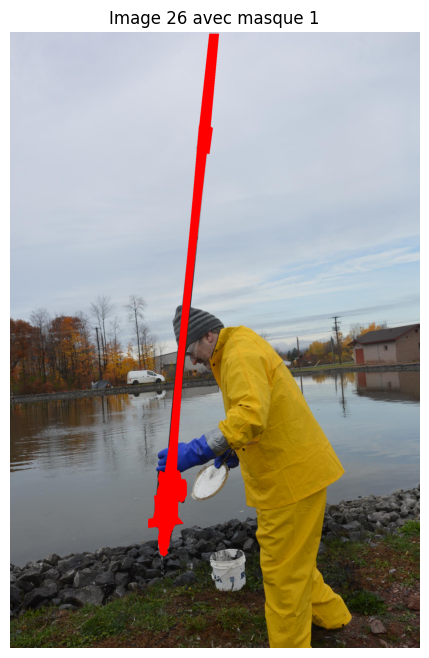

In [ ]:
#affichage d'un mask du dataset pour verifier qu'il fonctionne
#image_test = 1
#objet_test = 0

#image, target = dataset[image_test]
#plt.imshow(Image.fromarray(target['masks'][objet_test].mul(255).byte().cpu().numpy()))
#plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Définir l’image et l’objet à visualiser
image_index = 26
object_index = 1

# Récupération de l’image et du masque
image, target = dataset[image_index]

# Convertir image PIL en numpy
image_np = np.array(image)

# Extraire le masque de l’objet demandé
if object_index < target['masks'].shape[0]:
    mask = target['masks'][object_index].cpu().numpy()

    # Créer une copie de l'image pour superposition
    overlay = image_np.copy()

    # Appliquer le masque en rouge (pixels où mask == 1)
    overlay[mask == 1] = [255, 0, 0]

    # Affichage
    plt.figure(figsize=(8, 8))
    plt.title(f"Image {image_index} avec masque {object_index}")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()
else:
    print(f" L'objet {object_index} n'existe pas dans l'image {image_index} (max = {target['masks'].shape[0] - 1})")

# 3. Définition du modèle
On va utiliser le modèle Mask-RCNN qui est basé sur le modèle Faster R-CNN mais qui va permettre de générer des masks pour chaque objet detecter et donc nous permettre de réaliser une segmentation d'instance

On peut utiliser ce modèle de deux manières différentes :
- D’un coté on pourra charger ce modèle avec les paramètres prés-entraînées ( sur COCO par exemple) pour n’adapter que la dernière couche du ML avec notre data set.
- De l’autre coté on pourra entièrement changer la “colonne vertébrale” de ce modèle si on considère que le traitement est trop profond pour l’application souhaitée. (permet des calculs plus rapides mais un entraînement beaucoup plus long)
On commencera donc par utiliser le modèle avec les paramètres pré-chargés sur COCO afin d’obtenir un premier résultat sans trop d’entraînement (difficulté d’obtenir les images du dataset).

## Utlisation de mask R-CNN pretrained on COCO
Dans notre cas, on veut affiner un modèle près-entrainé car on va apprendre avec peu de données. On va donc charger ce modèle entrainé sur COCO

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    ##ADD POUR MODIFIER LE # MAX D'OBJET DETECTES LORS DE LA PRED (default = 100)
    model.roi_heads.detections_per_img=300

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model




Le modèle est prêt à être entrainé et testé

## Fonctions d'entrainement et de tests
Dans references/detection/, on a un certain nombre de fonctions permettant de simplifier les calculs d'entrainement et de tests. Ici on utilisera references/detection/engine.py, references/detection/utils.py et references/detection/transforms.py.

On va les copier ici pour pouvoir y avoir accès dans le notebook

In [ ]:

%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../



Cloning into 'vision'...
remote: Enumerating objects: 642604, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (294/294), done.
remote: Total 642604 (delta 273), reused 141 (delta 140), pack-reused 642170 (from 3)
Receiving objects: 100% (642604/642604), 1.18 GiB | 50.40 MiB/s, done.
Resolving deltas: 100% (601124/601124), done.
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version


## Data augmentation
On va maintenant écrire des fonctions pour la data augmentation / transformation, qui va venir influencer dans `refereces/detection` qu'on vient de récupérer


In [ ]:
#  1. Supprimer les anciennes versions
!rm -rf vision
!rm -f engine.py utils.py transforms.py coco_eval.py coco_utils.py

#  2. Cloner la dernière version officielle de torchvision
!git clone https://github.com/pytorch/vision.git

#  3. Copier les bons fichiers dans le dossier courant
!cp vision/references/detection/*.py .


Cloning into 'vision'...
remote: Enumerating objects: 642604, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (294/294), done.
remote: Total 642604 (delta 273), reused 141 (delta 140), pack-reused 642170 (from 3)
Receiving objects: 100% (642604/642604), 1.18 GiB | 50.27 MiB/s, done.
Resolving deltas: 100% (601124/601124), done.


In [ ]:
# Depuis Colab :
%cd /content/
!git clone https://github.com/pytorch/vision.git
!cp vision/references/detection/*.py .


from engine import evaluate
import utils
import random
from torchvision import transforms as T


class ComposeWithTarget:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensorWithTarget:
    def __call__(self, image, target):
        return T.ToTensor()(image), target

class RandomHorizontalFlipWithTarget:
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            # On récupère les dimensions AVANT de transformer en Tensor
            width, _ = image.size  # image est encore une PIL.Image ici
            image = F.hflip(image)
            target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target

def get_transform(train=True):
    transforms = [ToTensorWithTarget()]
    if train:
        transforms.insert(0, RandomHorizontalFlipWithTarget(0.5))  # flip avant ToTensor
    return ComposeWithTarget(transforms)


/content
fatal: destination path 'vision' already exists and is not an empty directory.


On notera que nous n'avons pas besoin d'ajouter de normalisation, moyenne ni de redimensionnement d'image dans les transformations de données, car celles-ci sont gérées en interne par le modèle Mask R-CNN.

## On regroupe tout
Maintenant qu'on a tout ce qu'il faut, on va instancier nos jeux de données pour l'apprentissage et pour les tests

In [ ]:
# On définie nos datasets avec ou non l'augmentation
dataset = laituesDatasetV03(dataset_directory, get_transform(train=True))
dataset_test = laituesDatasetV03(dataset_directory, get_transform(train=False))


# on sépare les datasets d'entrainement et de test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
indices_test = torch.randperm(len(dataset_test)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:])
dataset_test = torch.utils.data.Subset(dataset_test, indices_test[:])

# On selectionne les "lecteurs" de nos datasets, num_workers = 4 par default
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
print(f'nombre d image dans le dataset : {len(dataset)}' )
print(f'nombre d image dans le dataset test : {len(dataset_test)}')

nombre d image dans le dataset : 93
nombre d image dans le dataset test : 93


On va instancier le modèle et l'optimisateur

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# notre dataset contient deux classes : les salades et la terre
num_classes = 2

# On telecharge le modèle pretrained on coco
model = get_instance_segmentation_model(num_classes)
# on selectionne un apparreil utilisant un gpu
model.to(device)


# on construit notre optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# notre learning rate décrois au fur et à mesure des epochs
# 10x toutes les 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)




# model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 205MB/s]


Function TRAIN

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    dict_loss = []
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)



    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())


        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    print ('=======================================')

    print (f'epoch : {epoch}/{num_epochs} , loss value : {loss_value}')

    print ('=======================================')
    writer.add_scalar('loss_value#', loss_value, epoch)
    dict_loss.append(loss_value)
    writer.flush()
    return dict_loss

# 4. Entrainement


## Entrainement sur 10 epoch

In [ ]:
# === 1. Importations ===
import torch
import math
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms as T
import torchvision.transforms.functional as F
from engine import train_one_epoch
from PIL import Image
import utils  # doit contenir collate_fn et MetricLogger

# === 2. Transformations personnalisées ===
class ComposeWithTarget:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensorWithTarget:
    def __call__(self, image, target):
        return T.ToTensor()(image), target

def get_transform(train=True):
    transforms = [ToTensorWithTarget()]
    return ComposeWithTarget(transforms)

# === 3. Scheduler de warmup ===
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha
    return LambdaLR(optimizer, lr_lambda=f)

# === 4. Visualisation des prédictions ===
def visualize_prediction(model, data_loader, device, num_images=1):
    model.eval()
    images, _ = next(iter(data_loader))
    images = list(img.to(device) for img in images)

    with torch.no_grad():
        outputs = model(images)

    for i in range(min(num_images, len(images))):
        image_np = images[i].permute(1, 2, 0).cpu().numpy()
        masks = outputs[i]['masks'] > 0.5

        plt.figure(figsize=(8, 8))
        plt.imshow(image_np)
        for m in masks:
            mask = m.squeeze().cpu().numpy()
            plt.imshow(mask, alpha=0.4)
        plt.axis('off')
        plt.title("Prediction")
        plt.show()

# === 5. Boucle d'entraînement ===
def train_model(model, train_loader, optimizer, device, num_epochs=10):
    model.to(device)
    warmup_iters = min(1000, len(train_loader) - 1)
    lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor=1.0 / 1000)

    for epoch in range(num_epochs):
        print(f"\n+++++++++++++++++++++++++++")
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()

        try:
            train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=5)
            lr_scheduler.step()
        except Exception as e:
            print(f" Erreur à l'epoch {epoch+1} : {e}")

        # Optionnel : visualisation
        # visualize_prediction(model, train_loader, device, num_images=1)

# === 6. Exemple d’appel (à adapter à ton modèle et dataset) ===
# Assure-toi que :
# - `model` est bien défini
# - `data_loader` utilise `collate_fn=lambda x: tuple(zip(*x))`
# - `optimizer` est défini (e.g., Adam)

train_model(model, data_loader, optimizer, device, num_epochs=10)



+++++++++++++++++++++++++++
Epoch 1/10


/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/47]  eta: 0:02:10  lr: 0.000000  loss: 4.0289 (4.0289)  loss_classifier: 0.5869 (0.5869)  loss_box_reg: 0.0230 (0.0230)  loss_mask: 2.6546 (2.6546)  loss_objectness: 0.5359 (0.5359)  loss_rpn_box_reg: 0.2286 (0.2286)  time: 2.7814  data: 0.6353  max mem: 2215
Epoch: [0]  [ 5/47]  eta: 0:00:29  lr: 0.000000  loss: 4.0289 (4.1248)  loss_classifier: 0.5618 (0.5687)  loss_box_reg: 0.0362 (0.0477)  loss_mask: 2.7373 (2.8805)  loss_objectness: 0.3825 (0.4481)  loss_rpn_box_reg: 0.1379 (0.1799)  time: 0.6957  data: 0.2145  max mem: 2384
Epoch: [0]  [10/47]  eta: 0:00:20  lr: 0.000000  loss: 4.0018 (4.0108)  loss_classifier: 0.5630 (0.5630)  loss_box_reg: 0.0322 (0.0388)  loss_mask: 2.6077 (2.7127)  loss_objectness: 0.4450 (0.4652)  loss_rpn_box_reg: 0.2163 (0.2311)  time: 0.5508  data: 0.2306  max mem: 2385
Epoch: [0]  [15/47]  eta: 0:00:15  lr: 0.000000  loss: 3.9591 (3.9087)  loss_classifier: 0.5634 (0.5634)  loss_box_reg: 0.0337 (0.0454)  loss_mask: 2.5853 (2.6601)  loss_ob

# **On sauvegarde le modele sur le drive**

In [ ]:
#%tensorboard --logdir runs

# === 1. Monter Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === 2. Créer le dossier de sauvegarde (si besoin) ===
import os

# Chemin vers ton dossier Drive (tu peux le modifier)
save_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset'

# === 3. Sauvegarder le modèle (après l'entraînement) ===
import torch

# Nom de fichier : tu peux le changer selon l’époque ou une description
model_path = os.path.join(save_dir, 'maskrcnn_final_model.pkl')

# Sauvegarde des poids du modèle (uniquement les poids)
torch.save(model.state_dict(), model_path)

print(f" Modèle sauvegardé avec succès à : {model_path}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Modèle sauvegardé avec succès à : /content/drive/MyDrive/Colab Notebooks/dataset-jauge-V2/maskrcnn_final_model.pkl


# 5. Utilisation du modèle
On va récupérer un modèle entraîné (dans l'environnement d'éxécution ou stocké en local) pour réaliser des prédictions à l'aide du GPU de Google Colab

## On load le modèle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Modèle chargé depuis : /content/drive/MyDrive/Colab Notebooks/dataset-jauge-V2/Resultats/maskrcnn_final_model.pkl
Modèle prêt à l'inférence.
Image en paysage détectée : rotation automatique effectuée.


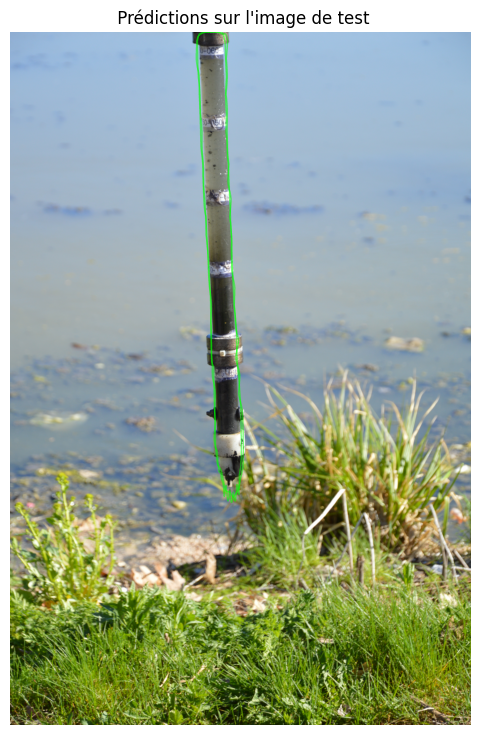

In [ ]:
# === 1. Importations nécessaires ===
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import os

from google.colab import drive, files

# === 2. Monter Google Drive ===
drive.mount('/content/drive')

# === 3. Définir le chemin du modèle enregistré dans le Drive ===
model_path = "/content/drive/MyDrive/Colab Notebooks/dataset-jauge-V2/Resultats/maskrcnn_final_model.pkl"

# === 4. Définir le modèle ===
# Assure-toi que cette fonction est définie dans ton notebook ou importée correctement
def get_instance_segmentation_model(num_classes):
    import torchvision
    from torchvision.models.detection import MaskRCNN
    from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

    # Charger backbone pré-entraîné
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    model = MaskRCNN(backbone, num_classes=num_classes)
    return model

model = get_instance_segmentation_model(2)  # 2 classes : fond + objet

# === 5. Charger les poids du modèle ===
try:
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    print(f" Modèle chargé depuis : {model_path}")
except Exception as e:
    print(" Fichier non trouvé ou mauvais format :", e)
    print("Veuillez charger manuellement un fichier .pkl depuis votre ordinateur.")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    model.load_state_dict(torch.load(filename, map_location='cpu'))
    print(f"Modèle chargé depuis : {filename}")

# === 6. Préparer l'appareil (GPU si dispo) ===
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

print("Modèle prêt à l'inférence.")


# === 7. Charger une image de test ===
img_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/240507-IVEO-LVLT/240507-IVEO-LVLT-E01/240507-IVEO-LVLT-E01-0003.JPG"
image = Image.open(img_path).convert("RGB")

# Détection de l'orientation : rotation automatique si l'image est en paysage
width, height = image.size
if width > height:
    image = image.rotate(90, expand=True)  # Rotation antihoraire pour passer en portrait
    print("Image en paysage détectée : rotation automatique effectuée.")
else:
    print("Image déjà en portrait : pas de rotation nécessaire.")


# === 8. Appliquer la transformation et prédire ===
img_tensor = F.to_tensor(image).unsqueeze(0).to(device)
with torch.no_grad():
    prediction = model(img_tensor)

# === 9. Afficher les résultats ===
pred = prediction[0]
threshold = 0.5

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for i in range(len(pred["boxes"])):
    score = pred["scores"][i].item()
    if score > threshold:
        #box = pred["boxes"][i].cpu().numpy()
        mask = pred["masks"][i, 0].cpu().numpy()
       # ax.add_patch(plt.Rectangle((box[0], box[1]),
                      #             box[2] - box[0],
                         #          box[3] - box[1],
                                #   fill=False, color='red', linewidth=2))
        ax.contour(mask > 0.5, colors='lime', linewidths=1, alpha=0.5)

plt.title(" Prédictions sur l'image de test")
plt.axis("off")
plt.show()


## On fait des predictions sur des images

In [ ]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class image_loader(torch.utils.data.Dataset) :
  def __init__(self, img_path, transforms=None) :
    self.img_path = img_path
    self.transforms = transforms
    # self.img_path = img_path

  def __getitem__(self,idx):
    img = Image.open(self.img_path).convert("RGB")

    boxes = torch.as_tensor([[]], dtype=torch.float32)
    labels = torch.ones((1,), dtype=torch.int64)
    masks = torch.as_tensor([[]], dtype=torch.uint8)
    image_id = torch.tensor([idx])
    area = torch.tensor([0])
    iscrowd = torch.zeros((1,), dtype=torch.int64)


    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

In [ ]:
import imageio
from skimage.color import rgb2gray

# Post-traitement

## post-traitement qui sort l'image de base et l'image de base filtrée par le mask en nuances de gris


---



In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio
from skimage.color import rgb2gray

import os
import torch

# Remplace par ton dossier contenant les images
image_folder = "/content/drive/MyDrive/Colab Notebooks/dataset-jauge-V2"

# Liste des fichiers image (par exemple .jpg, .png)
image_list = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Trier les fichiers par ordre alphabétique
image_list = sorted(image_list)

# Affichage
print(image_list)

def getBoxes(boxes):
    Boxes = []
    for tensor_box in boxes:
        box = [tensor_box[i].item() for i in range(4)]
        Boxes.append(box)
    return Boxes

def afficheResultats(image_path, prediction, image_name="image", limit_score=0.7):
    im = imageio.imread(image_path)
    im_gray = rgb2gray(im)

    dim = im.shape
    rects = getBoxes(prediction[0]["boxes"])
    nb_pred = len(rects)
    nb_true_pred = nb_pred

    mask = np.zeros((dim[0], dim[1]))
    mask2 = np.zeros((dim[0], dim[1]))
    image2 = np.zeros((dim[0], dim[1], 3))

    if nb_pred == 0:
        print("Aucune prédiction.")
        return 0

    box = rects[0]
    score = prediction[0]['scores'][0].item()
    print("Score de la meilleure prédiction :", score)
    text = str(round(score, 4))
    color = (0, 255, 0) if score >= limit_score else (0, 0, 255)
    if score < limit_score:
        nb_true_pred -= 1
    else:
        centerX = int((box[0] + box[2]) / 2)
        centerY = int((box[1] + box[3]) / 2)
        center_coordinates = (centerX, centerY)
        image = cv2.circle(im.copy(), center_coordinates, 4, (255, 0, 0), -1)

        image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        image = cv2.putText(image, text, (int(box[0]), int(box[1]) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        raw_mask = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
        mask += raw_mask
        seuil = 100
        mask2 = mask > seuil
        im_filter = im_gray * mask2

        image2[:, :, :] = image
        if np.max(mask) > 0:
            image[:, :, 0] = image[:, :, 0] - image[:, :, 0] * mask / np.max(mask) + 255 * (mask / np.max(mask))
        else:
            image[:, :, 0] = image[:, :, 0]

        # Affichage
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(im)
        plt.axis("off")
        plt.title(f"Prédictions: {nb_pred} - score max: {score:.4f}")

        plt.subplot(1, 2, 2)
        plt.imshow(im_filter, cmap="gray")
        plt.axis("off")
        plt.title(image_name)
        plt.tight_layout()
        plt.show()

        return nb_true_pred

def saveResultat(im_filter, img_name):
    cv2.imwrite(f"{img_name}.JPG", im_filter)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def load_image_as_tensor(path):
    from PIL import Image
    from torchvision import transforms
    image = Image.open(path).convert("RGB")
    transform = transforms.ToTensor()
    return transform(image).unsqueeze(0)  # [1, 3, H, W]

# Boucle sur toutes les images
for filename in image_list:
    path = os.path.join(image_folder, filename)
    image_tensor = load_image_as_tensor(path).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)

    print(f"\nTraitement de l’image : {filename}")
    afficheResultats(path, prediction, image_name=filename)



['20240705_085147.jpg']

🖼️ Traitement de l’image : 20240705_085147.jpg


<ipython-input-31-eb2320e4472d>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(image_path)


Score de la meilleure prédiction : 0.45919156074523926


In [ ]:
print(image_list)
image_list=sorted(image_list)
image_list

['20240705_085147.jpg']


['20240705_085147.jpg']

<ipython-input-64-92167d95edee>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path)


201022-CGEI-GREN-E01-0001 0.9440414905548096


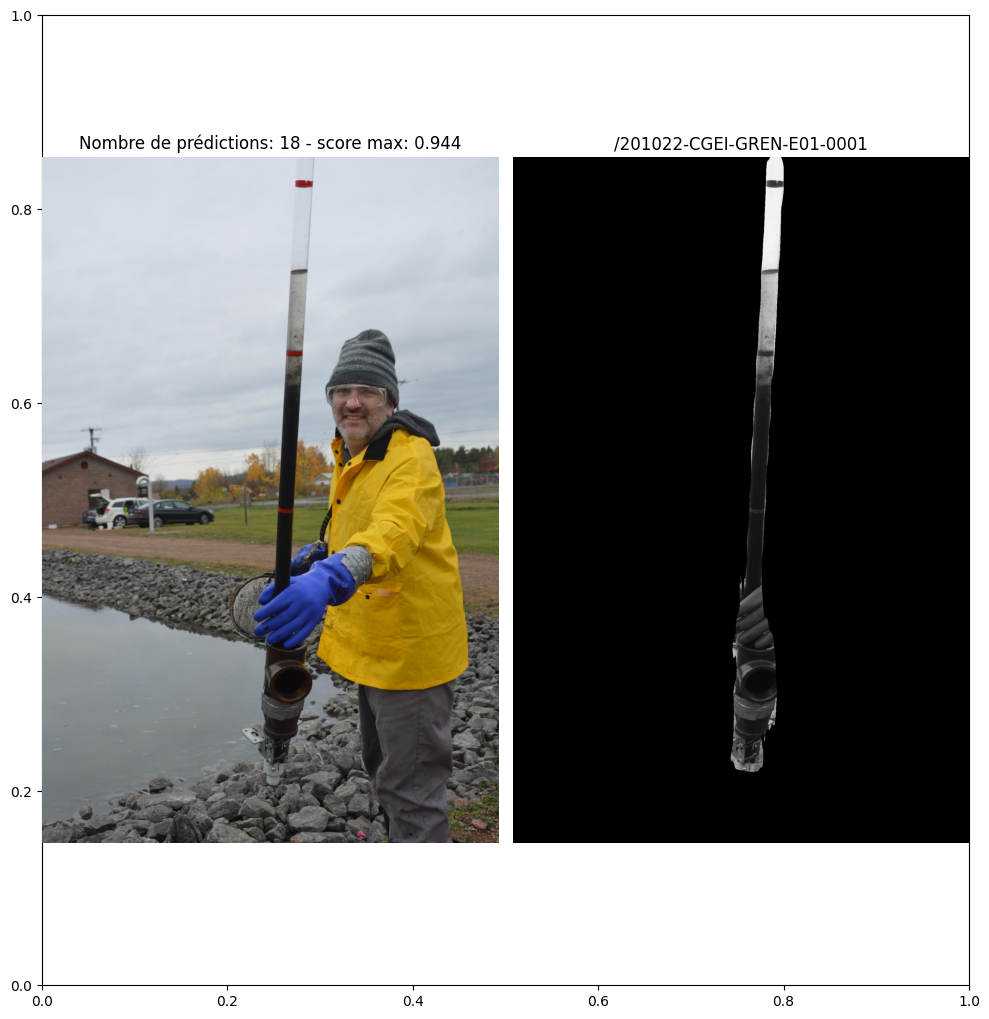

201022-CGEI-GREN-E01-0002 0.8505411148071289


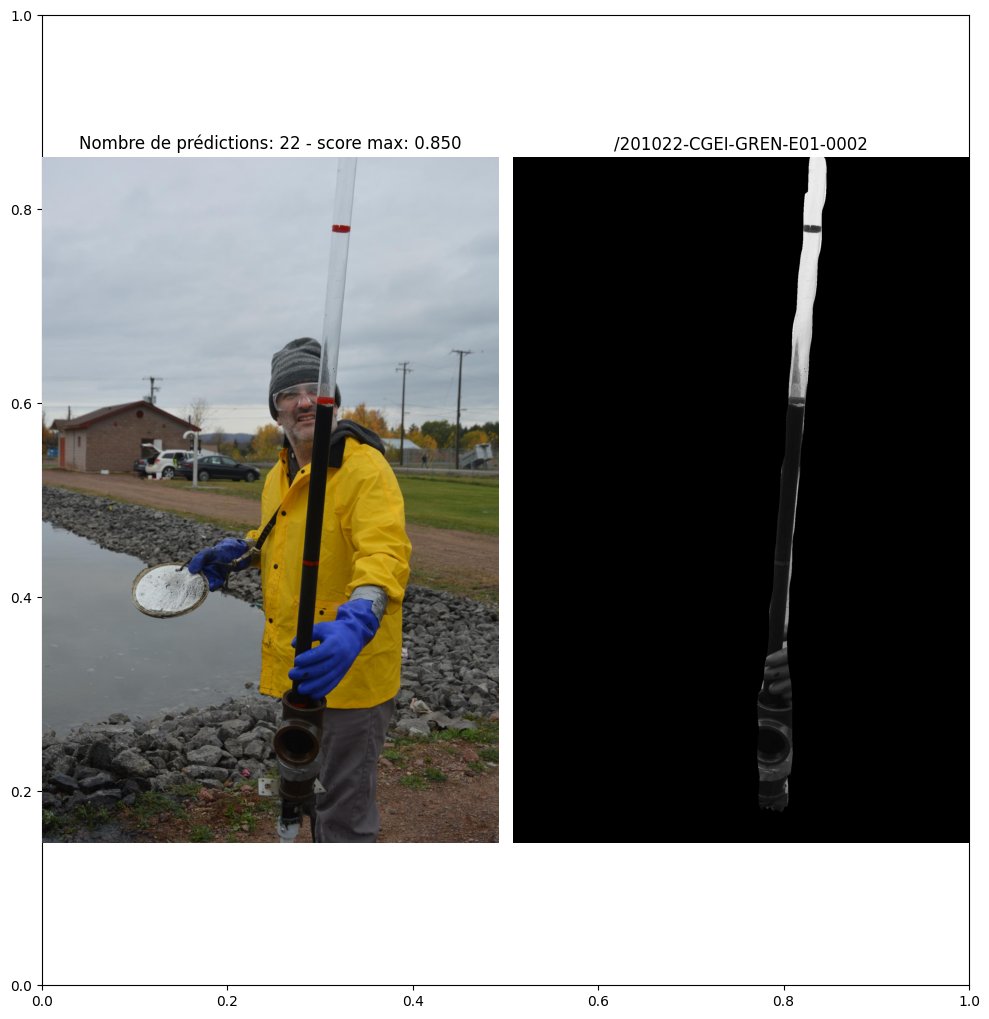

201022-CGEI-GREN-E01-0003 0.8878068327903748


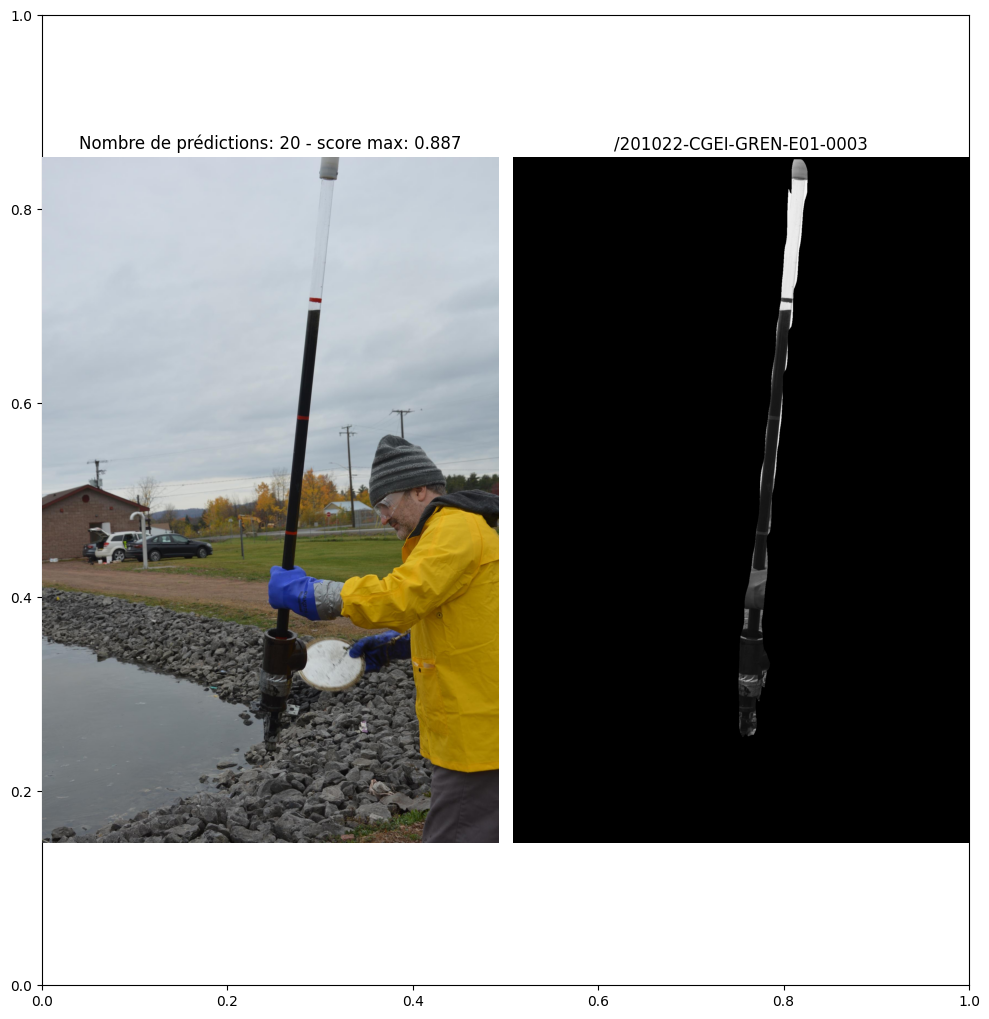

201022-CGEI-GREN-E01-0004 0.876539945602417


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff741f0cc20> (for post_execute):


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import imageio
from skimage.color import rgb2gray

image_path = '/content/drive/MyDrive/Colab Notebooks/dataset-jauge-V2/'
image_list = os.listdir(image_path)
image_list = sorted([i for i in image_list if i[-3:].upper() == "JPG"])

# Fonction pour extraire les coordonnées de la bounding box
def getBoxes(boxes):
    Boxes = []
    for i in range(len(boxes)):
        tensor_box = boxes[i]
        box = []
        for k in range(4):
            box.append(tensor_box[0].item())
        Boxes.append(box)
    return Boxes

# Parcours des images
for i in range(len(image_list)):

    image_path_resultats = "/content/drive/MyDrive/Colab Notebooks/dataset-jauge-V2/Resultats"
    os.makedirs(image_path_resultats, exist_ok=True)

    image_name = "/" + image_list[i][:-4]
    path = image_path + image_name + ".JPG"

    # Chargement image + transformation
    tensor_img, target = image_loader(path, get_transform(train=False))[0]

    # Prédiction
    model.eval()
    with torch.no_grad():
        pred = model([tensor_img.to(device)])

    limit_score = 0.12
    im = imageio.imread(path)
    im_gray = rgb2gray(im)
    image = im.copy()
    dim = image.shape
    rects = getBoxes(pred[0]["boxes"])
    nb_pred = len(rects)
    nb_true_pred = nb_pred
    mask = np.zeros((dim[0], dim[1]))
    mask2 = np.zeros((dim[0], dim[1]))
    image2 = np.zeros((dim[0], dim[1], 3))

    if nb_pred == 0:
        print("Aucune prédiction pour", image_name[1:])
        continue

    box = rects[0]
    score = pred[0]['scores'][0].item()
    text = str(round(score, 4))
    color = (0, 255, 0) if score >= limit_score else (0, 0, 255)

    if score >= limit_score:
        # Centre de la box
        centerX = int((box[2] + box[0]) / 2)
        centerY = int((box[3] + box[1]) / 2)
        center_coordinates = (centerX, centerY)
        cv2.circle(image, center_coordinates, 1, (0, 0, 255), 6)

        # Rectangle et score
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 1)
        cv2.putText(image, text, (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Application du mask
        mask += pred[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
        seuil = 100
        mask2 = mask > seuil
        im_filter = im_gray * mask2

        if np.max(mask) > 0:
            image[:, :, 0] = image[:, :, 0] - image[:, :, 0] * mask / np.max(mask) + 255 * (mask / np.max(mask))
        else:
            image[:, :, 0] = image[:, :, 0]

        # Sauvegarde
        save_path = image_path_resultats + image_name + '.JPG'
        cv2.imwrite(save_path, im_filter * 255)

    print(image_name[1:], score)

    # Si tu veux voir les résultats :

    plt.subplots(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(im)
    plt.title("Nombre de prédictions: " + str(nb_pred) + " - score max: " + str(score)[:5])

    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(im_filter, cmap="gray")
    plt.title(str(image_name))
    plt.tight_layout()
    plt.show()


    # Arrêt si le score est trop bas
    if score < limit_score:
        print("Arrêt - prédiction trop faible:", image_name[1:], score)
        break


gtffdgdf

In [ ]:
import matplotlib.pyplot as plt
import cv2

def getBoxes(boxes) :
  Boxes = []
  for i in range(len(boxes)) :
    tensor_box = boxes[i]
    box = []
    for k in range(4) :
      box.append(tensor_box[0].item())
    Boxes.append(box)
  return Boxes

def afficheResulats(image, prediction, limit_score=0.7) :
  # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  im = imageio.imread((path))
  im2 = np.zeros((im.shape[0], im.shape[1],3))

  print(type(im2))
  print(type(im))
  im_gray = rgb2gray(im)

  dim = image.shape
  #print("Dimensions de l'image test:",dim)
  rects = getBoxes(prediction[0]["boxes"])
  #print("Nombre de prédictions:",len(prediction[0]["boxes"]))im = imageio.imread((path))
  nb_pred = len(rects)
  nb_true_pred = nb_pred
  mask = np.zeros((dim[0], dim[1]))
  mask2 = np.zeros((dim[0], dim[1]))
  mask3D = np.zeros((dim[0], dim[1],3))

  box = rects[0]
  score = prediction[0]['scores'][0].item()
  print(score)
  text = str(round(score,4))
  color = (0, 255, 0)
  if(score<limit_score) :
    color = (0, 0, 255)
    nb_true_pred -=1
  if(score>limit_score):

    #point au centre de l'objet
    centerX = int( (box[2] + box[0])/2)
    centerY = int( (box[3] + box[1])/2)
    center_coordinates = (centerX, centerY)
    cv2.circle(image, center_coordinates, 1, (0,0,255),6)

    #rectangle de la bounding box
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 1)
    cv2.putText(image, text, (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color,1)

    #print("im*mask:",image[:,:,0]*mask,"mask:",len(mask),"prediction:",len(prediction[0]['masks'][0, 0]))
    mask += prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
    seuil = 100
    mask2 = mask > seuil
    im_filter = im_gray*mask2
    mask3=mask2/(mask2+0.0000000000000001)

    for i in range(3):
      mask3D[:,:,i] = mask3

  im2= im*mask3D
  im2 = im2.astype(int)


  print(np.max(im2),np.max(im))

  #print("Nombre de pixels verticaux:", len(im_filter),"Nombre de pixels horizontaux:", len(im_filter[0]))
  # Coordonées des points différenets de 0 dans l'image
  a = np.where(im_filter!=0)
  print("Nombre de pixels verticaux de l'image finale:", max(a[0])-min(a[0]),"Nombre de pixels horizontaux de l'image finale:", max(a[1])-min(a[1]))
  image[:,:,0] = image[:,:,0] - image[:,:,0]*mask/np.max(mask) + 255*(mask/np.max(mask))

  plt.subplots(figsize=(20, 10))
  plt.subplot(1,4,1),
  plt.axis("off")
  plt.imshow(im)
  plt.title("Nombre de prédictions" + str(nb_pred) + " " + "score max:" + str(score)[:5])
  #plt.tight_layout()

  plt.subplot(1,4,2),
  plt.axis("off")
  plt.imshow(im[min(a[0]):max(a[0]),min(a[1]):max(a[1]),:])
  #plt.tight_layout()

  plt.subplot(1,4,3),
  plt.axis("off")
  plt.imshow(im2[min(a[0]):max(a[0]),min(a[1]):max(a[1]),:])
  plt.title(str(image_name))
  #plt.tight_layout()

  plt.subplot(1,4,4),
  plt.axis("off")
  plt.imshow(im_filter[min(a[0]):max(a[0]),min(a[1]):max(a[1])],cmap="gray")
  #plt.tight_layout()

  plt.show()
  return nb_true_pred

def saveResultat(image, img_name) :nb_pred = afficheResulats(image, pred, limit_score)
    cv2.imwrite("" + img_name + '.JPG', image)

## Exécution du post-traitement

<ipython-input-52-1b0c0c7b03be>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread((path))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
0.9440414905548096
232 248
Nombre de pixels verticaux de l'image finale: 2253 Nombre de pixels horizontaux de l'image finale: 193


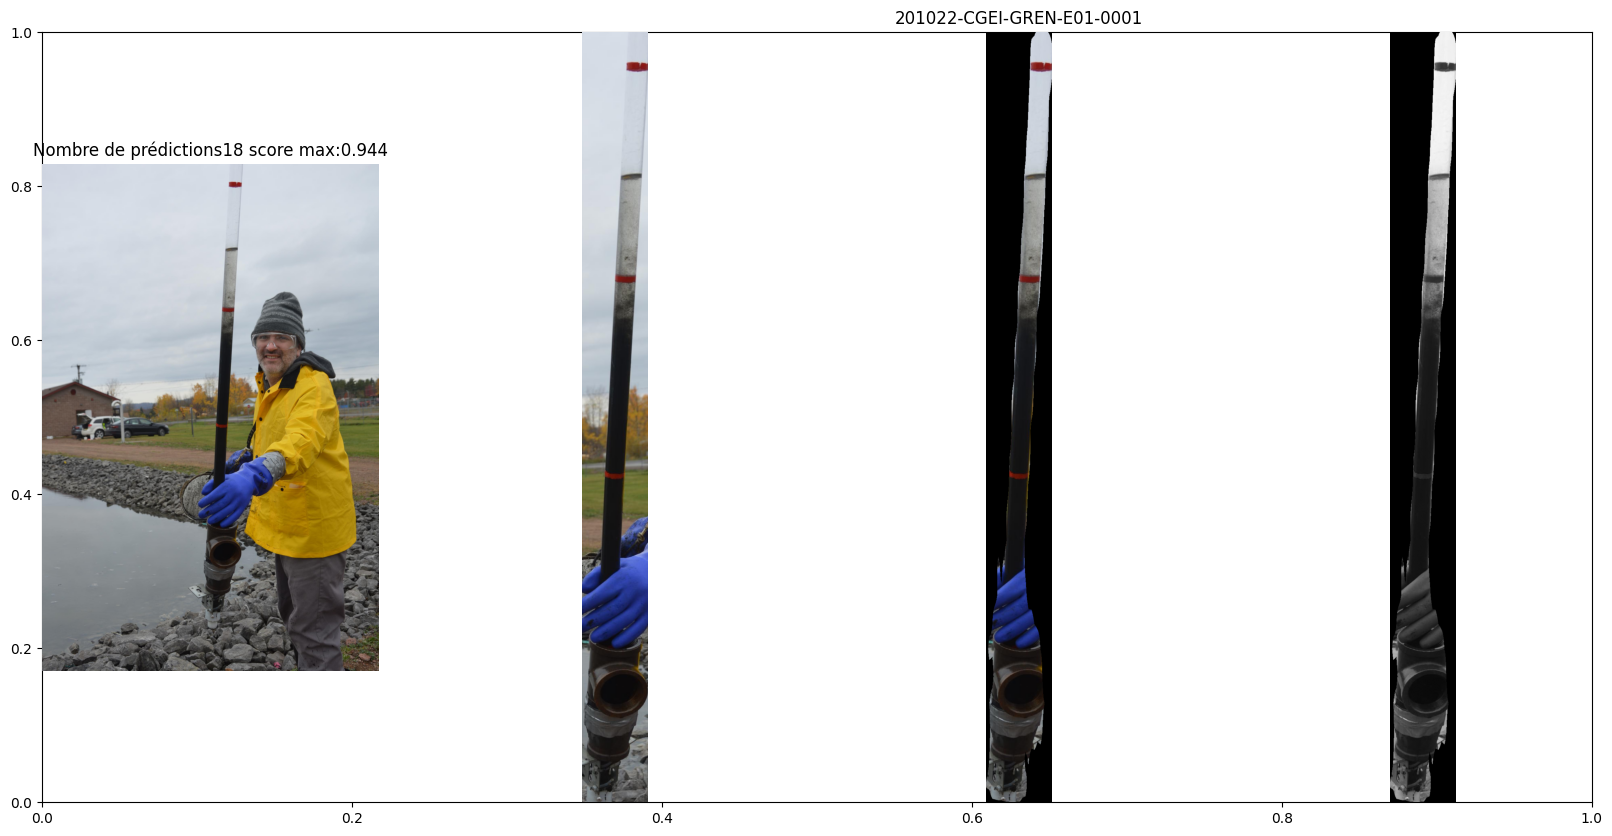

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/dataset-jauge-V2/'
image_name = "201022-CGEI-GREN-E01-0001"
path = image_path+image_name+".JPG"


## On ouvre notre image sur laquelle on va travailler
image = cv2.imread(path)

## On ouvre le tensor correspondant
tensor_img, target = image_loader(path,get_transform(train=False))[0]

## On réalise la prédiction
model.eval()
with torch.no_grad():
  pred = model([tensor_img.to(device)])

limit_score = 0.60
nb_pred = afficheResulats(image, pred, limit_score)
saveResultat(image, image_name)

In [ ]:
import matplotlib.pyplot as plt

def DisplayArea(image, prediction, limit_score, bins) :
  dim = image.shape
  rects = getBoxes(prediction[0]["boxes"])
  nb_pred = len(rects)
  nb_true_pred = nb_pred
  mask = np.zeros((dim[0], dim[1]))
  area_list = []
  for k in range(nb_pred):
      box = rects[k]
      score = prediction[0]['scores'][k].item()
      text = str(round(score,4))
      color = (0, 255, 0)
      if(score<limit_score) :
        color = (0, 0, 255)
        nb_true_pred -=1
      if(score>limit_score):

        #calcul de l'aire
        longeur = box[2]-box[0]
        largeur = box[3]-box[1]
        area = longeur*largeur
        area_list.append(area)
  plt.hist(area_list, bins)

  plt.title('nombre d objets :' + str(nb_true_pred))
  plt.xlabel('taille en pixel')
  plt.ylabel('nombre')
  plt.show()
  #return area_list